# Pyvista 101
I'm goign through the tutorial notebook but applied to the second simulation run, so that we can do some science with it too.

Pyvista works, but interactive plots only work in a regular python file and not in a jupyter notebook.

Need my standard Python 3.12.3 kernel.

In [1]:
import pyvista as pv
import os
import meshio as mo
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# mesh = pyvista.Plane().triangulate()
# submesh = mesh.subdivide(2, 'linear')
# submesh.plot(show_edges=True)

## Reading meshes from files

Reading in vtu files is done with meshio or pyvista. The pyvista mesh is an unstructered grid (= a grid of simple geometrical shapes in an irregular pattern). Unstructured grids can be orderly, but they don't need to be.

In [4]:
folder = "1" # loading and unloading of a 
compr = "10"
parent_dir = f'C:/Users/spaan/Thesis/SecondSesh_13-02-2025/Compression/data_run{folder}_{compr}/vtk/'
warp = 1


# reading vtu files
# specify full path to mesh
# Meshio:
meshes_meshio = []
n = 0
for subdir, dirs, files in os.walk(parent_dir):
        for file in files:
            fdir = parent_dir + file

            mesh = mo.read(fdir)
            meshes_meshio.append(mesh)
            n +=1

print("Reading with meshio is done!")
print(type(mesh))


# Pyvista
meshes = []
n = 0
for subdir, dirs, files in os.walk(parent_dir):
        for file in files:
            fdir = parent_dir + file

            pv_mesh = pv.read(fdir)
            meshes.append(pv_mesh)
            n +=1

print(f"Reading with pyvista is done! Saved {len(meshes)} meshes.")
print(type(pv_mesh))


Reading with meshio is done!
<class 'meshio._mesh.Mesh'>
Reading with pyvista is done! Saved 41 meshes.
<class 'pyvista.core.pointset.UnstructuredGrid'>


### What we can do with the mesh
Points are the vertices of cells, or points on their own (think a point cloud). Cell is the geometry between points that defines the connectivity or topology of a mesh. 
Attributes are data values that live on either the points or cells of a mesh, so there's point data and cell data. 

For our grid, the data lives on the points. We have to assign the data to the grid in order to plot it. In our case, that's 'sol'.

c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


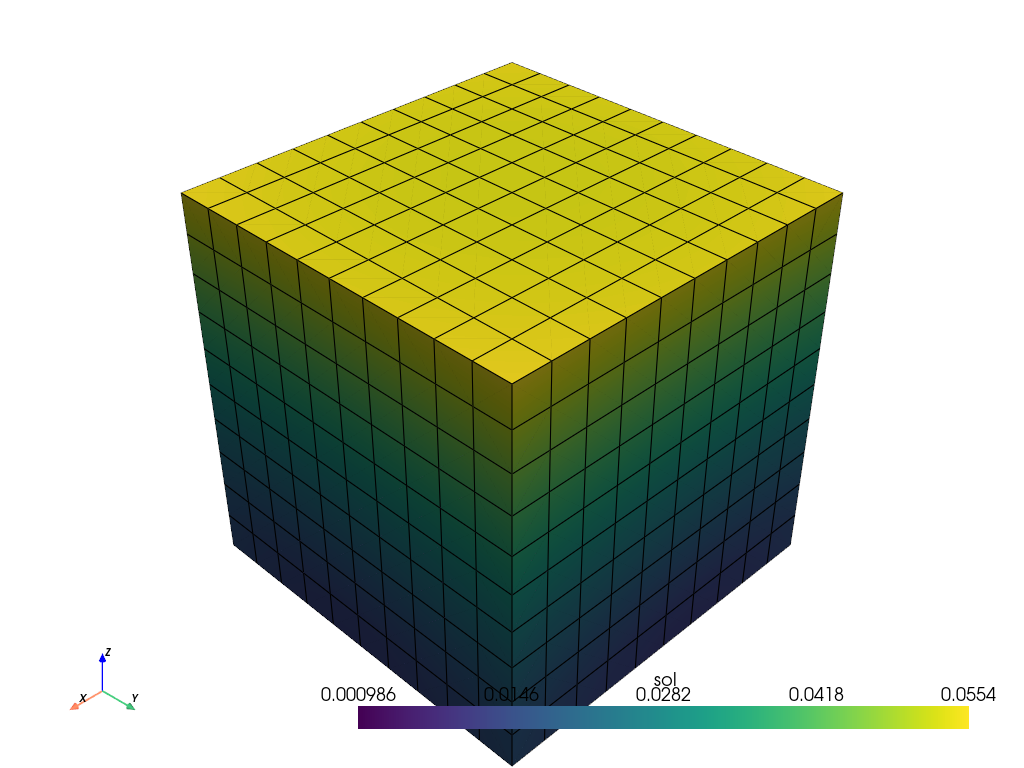

In [5]:
mesh = meshes[10]
mesh.point_data
mesh.plot(scalars = 'sol', show_edges = True)
#mesh.points


Cell volume didn't change because the mesh didn't update. It's always the same cube, despite the deformation. Assigning the scalar does not deform the mesh, it merely assigns the values. 

We have to create a `Plotter()` instance instead. This allows us to plot multiple meshes in one figure and gives a little more flexibility. A mesh or numpy array is assigned to the plotter, which then displays it. So I make a mesh, warp the mesh by the deformation, and scale so that the warp turns noticable.

The mesh has nodes, and a solution file. Each node is moved by the solution (= the deformation) which is a vector. Can I warp the mesh by a vector?

**Update:** Yes I can, see below! I have to specify the solution, which is a deformation, as vectors to warped_by_vector and then it works out. Oooooh and I can then assign the stresses to the cells. Hah, getting there.

c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


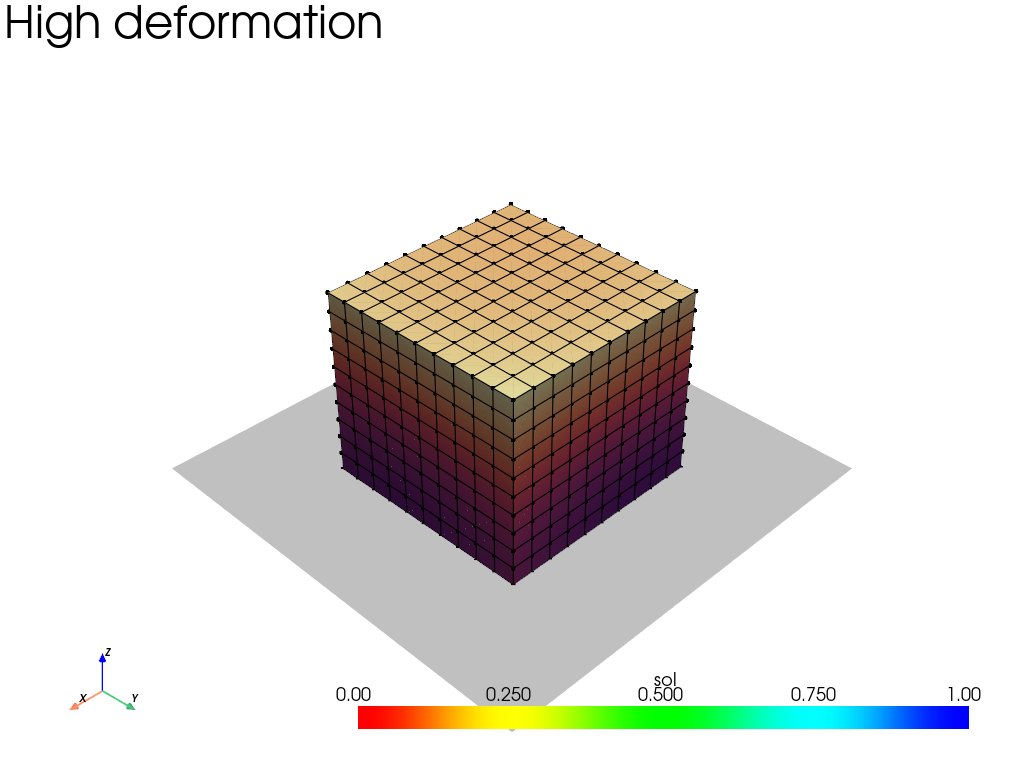

In [6]:
mesh_hi = meshes[20]
warped_mesh_hi = mesh_hi.warp_by_vector(vectors = 'sol', factor = warp)

# creating a str list of point labels
n_points = len(mesh_hi.points)
p_labels = list(map(str, np.arange(0, n_points)))
#print(point_labels)

pl = pv.Plotter()
pl.add_text("High deformation")
pl.add_mesh(warped_mesh_hi, scalars = 'sol', cmap = 'magma', show_edges=True, show_vertices=True)
pl.show_axes()
pl.add_floor(pad=1.0, color = 'silver')

# uncomment for point labels
# pl.add_point_labels(warped_mesh_hi.points, p_labels, font_size = 5, always_visible =True)

pl.show()

We can also look at slices of the object. The default coordinates are mid sections, but we can supply any x,y,z coordinate to plot.

c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


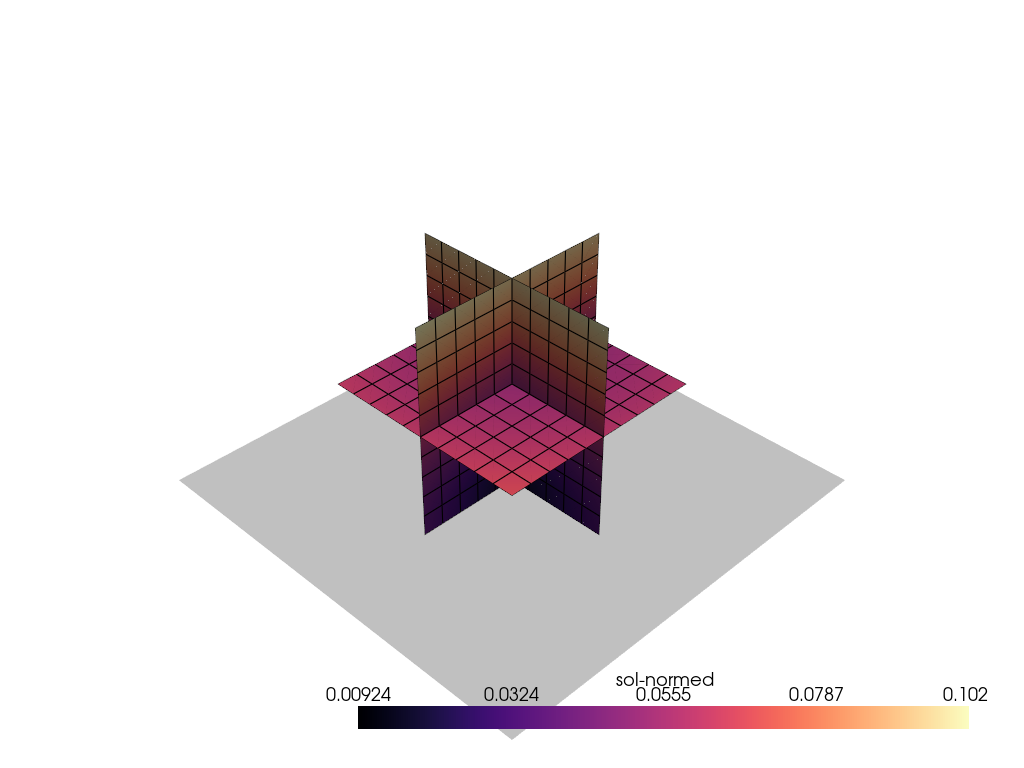

In [7]:
slices = mesh_hi.slice_orthogonal()
pl = pv.Plotter()
pl.add_mesh(slices, scalars = 'sol', show_edges = True, cmap = "magma")
pl.add_floor(pad=1.0, color = 'silver')
pl.show()

Aparently I can also give meshes cartoon edges, metallic sheen, smooth shading, etc. Really cool for later, not now.

#### GIFs
Now *this* is useful. Let's see if we can create a gif of the box.

*Notes: Okay first, why is the final minimum z entry not zero, and second, why is that colormap not sticking to the grid? WHy does it stay at zero? Must have something to do with how those points are updated, or what is mapped to the vertices, but I don't get it.*

*Update: definitely something with the scalrs setting. Look into it later, I have an idea but it's almost dinner time.*

In [8]:
# collect minimum and maximum uz values for setting the limits of the colormap
min_uz, max_uz = np.zeros(n), np.zeros(n)
for i, mesh in enumerate(meshes):
    min_u, max_u = mesh['sol'].min(axis=0), mesh['sol'].max(axis=0)
    min_uz[i], max_uz[i] = min_u[2], max_u[2]

print(max_uz.max())

3.1973317504707666e-07


In [9]:
# init_mesh = meshes[0].warp_by_vector('sol', factor = warp)
# init_mesh["uz"] = init_mesh['sol'][:,2]
# max_uz.max()

# gif_pl = pv.Plotter()
# gif_pl.add_mesh(init_mesh,show_edges=True, cmap = 'magma', clim=[min_uz[0], max_uz.max()])

# gif_pl.open_gif(f"box{folder}.gif")
# pts = init_mesh.points.copy() # returns a copy of the points of the mesh as a numpy array


# # I did it! Now why is the colormap not working
# for mesh in meshes[:31]:
#     # collect new coordinates
#     warped_mesh = mesh.warp_by_vector('sol', factor = warp)

#     # update the initial mesh with new coordinates
#     init_mesh.points[:,:] = warped_mesh.points[:,:]

#     init_mesh['sol'] = warped_mesh.points[:,:]
#     gif_pl.write_frame()

# gif_pl.close()


## Actual data analysis
**Q:** Why is the deformation not symmetric in the xy-plane? You can see it in the colormap, it's more deformed towards one corner. You can't see it in the mesh because the difference is so small, but the values and the colormap definitely show it. It also becomes more pronounced with increasing strain, and disappears with decreasing strain.

**Update to the question:** I plotted the bounds, and aparently the box turns??? Why???
The bounds run parallel to the coordinate axes, so the bos definitely turns around the z-axis which is really weird.

Hah, that's another thing: the colormap now just displays general deformation. I can also set it to just one axis, I hope, which would show what happens to each coordinate. 

* x, y-axes: perpendicular to the load, will likely show asymmetry
* z-axis: the deformation parallel to the load, will likely not show asymmetry


[[-0.00798025 -0.01516355  0.        ]
 [ 0.03727016 -0.00800919  0.        ]
 [-0.01513447  0.03008619  0.        ]
 ...
 [ 0.02630604  0.03200016 -0.06649994]
 [ 0.02630609  0.03200011 -0.07599996]
 [ 0.02630612  0.03200008 -0.08549998]]


c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


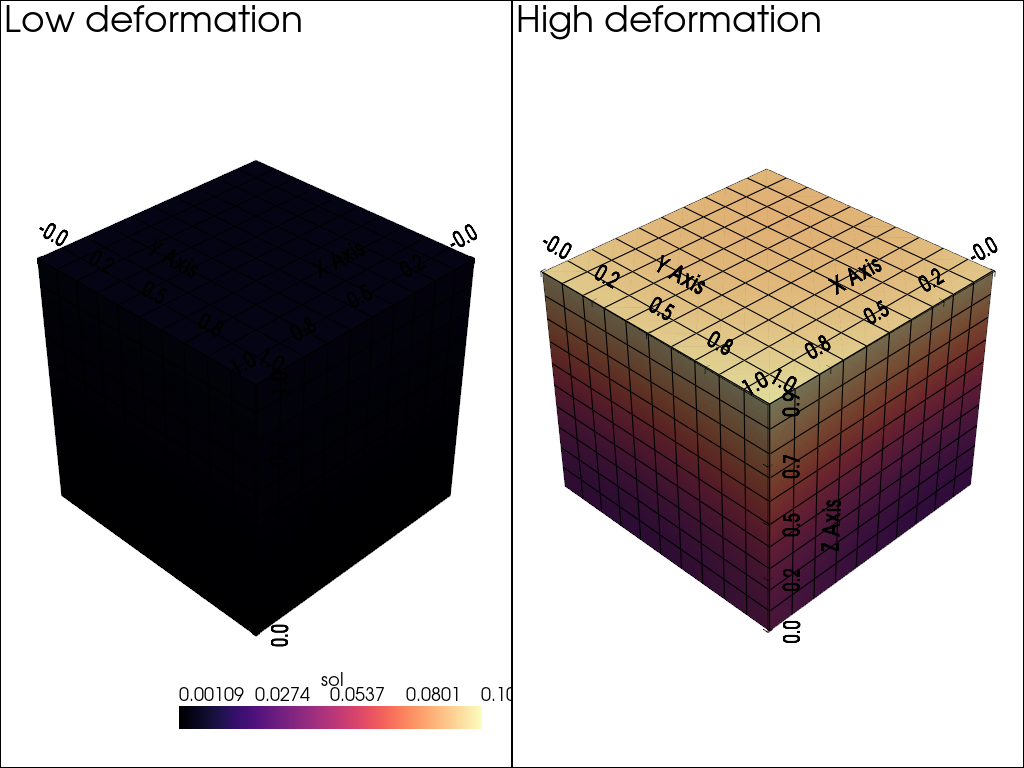

In [10]:
mesh_hi = meshes[int(n/2)]
mesh_lo = meshes[1]

warped_mesh_hi = mesh_hi.warp_by_vector(vectors = 'sol', factor = warp)
warped_mesh_lo = mesh_lo.warp_by_vector('sol', factor = warp)

print(mesh_hi['sol'])

# The deformation asymmetry, which turns out to be a rotation of the mesh???
pl = pv.Plotter(shape=(1, 2))
pl.subplot(0,0)
pl.add_text("Low deformation")
pl.show_bounds()
pl.add_mesh(warped_mesh_lo, scalars = 'sol', cmap = 'magma', show_edges=True)
pl.subplot(0,1)
pl.add_text("High deformation")
pl.show_bounds()
pl.add_mesh(warped_mesh_hi, scalars = 'sol', cmap = 'magma', show_edges = True)
pl.show()

### Computing cell sizes
Let's see if scaling the mesh by a factor also influences the volume. I'd assume so, meaning that we have to be very careful when we do or don't scale, because of course science should be done with the unscaled values.

*Update:* Lol, I plotted the deformation, not the volume. Oh well, see the neat notebook.

NameError: name 'node' is not defined

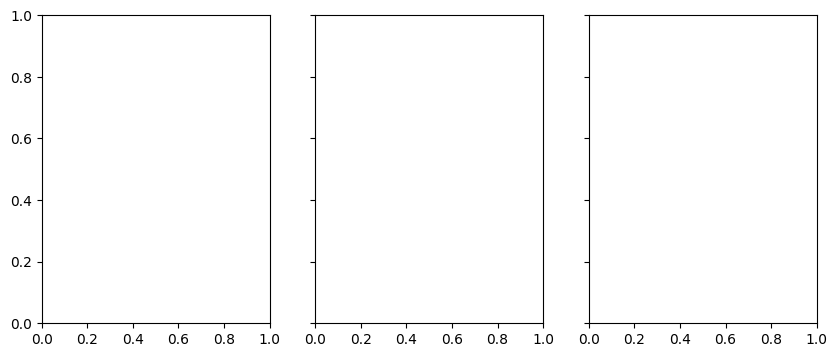

In [11]:
# saving deformations of nodes
nodes = [200, 800]
node_nums = np.arange(1,n+1)
u_node = np.zeros((n, 3, 2))
i = 0
for i, mesh in enumerate(meshes):
    u = mesh['sol']
    u_node[i,:, 0] = u[nodes[0],:]
    u_node[i,:, 0] = u[nodes[1],:]


f, (axx, axy, axz) = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
f.suptitle(f"Node {node} deformation - loading")


axx.plot(node_nums, u_node[:,0, 0], 'o', markersize=3)
axx.set_title('u_x')
axx.set_ylabel('u')
axx.set_xlabel('Step')
#axx.set_ylim(-0.0002, 0.0002)
axx.hlines(0,0, n, 'k', '--')

axy.plot(node_nums, u_node[:,1, 0], 'o', markersize=3)
axy.set_title('u_y')
axy.set_xlabel('Step')
axy.hlines(0,0, n, 'k', '--')

axz.plot(node_nums, u_node[:,2, 0], 'o', markersize=3)
axz.set_title('u_z')
axz.set_xlabel('Step')
axz.hlines(0,0, n, 'k', '--')

plt.show()

### Various widgets
There's a few options to interactively slice and crop, or even slide through the volume. See this page for an overview: https://docs.pyvista.org/examples/03-widgets/ \
We're highlighting two of them here, the plane widget and slider bar widget. 

Of course, interactive plotting doesn't work in jupyter, so we'll just have to add it to the python script.

Update: okay I don't understand that callback function. ANd the slice also doesn't work. Perhaps I have to call it in the terminal. Well, figure out later. \
Let's add the slider instead.

**Update Update:** `scalars = mesh.points[:, i]??? With i = the coordinate???`

##### Plane clipper

In [ ]:
# plane widget, for clipping
# this is not working yet. The slider is nicer.
p_plane = pv.Plotter()
p_plane.add_mesh(meshes[3])

def callback(normal, origin):
    slc = mesh.slice(normal=normal, origin=origin)
    origin = list(origin)
    origin[2] = slc.bounds[5]

p_plane.add_plane_widget(callback, normal_rotation = True)
p_plane.add_mesh_clip_plane(meshes[3])
# p_plane.show()

p_plane.plane_clipped_meshes


[UnstructuredGrid (0x25484d66fe0)
   N Cells:    600
   N Points:   847
   X Bounds:   5.000e-01, 1.000e+00
   Y Bounds:   0.000e+00, 1.000e+00
   Z Bounds:   0.000e+00, 1.000e+00
   N Arrays:   2]

##### Slider widget
For interactive stuff this needs to be run in the python file.

c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


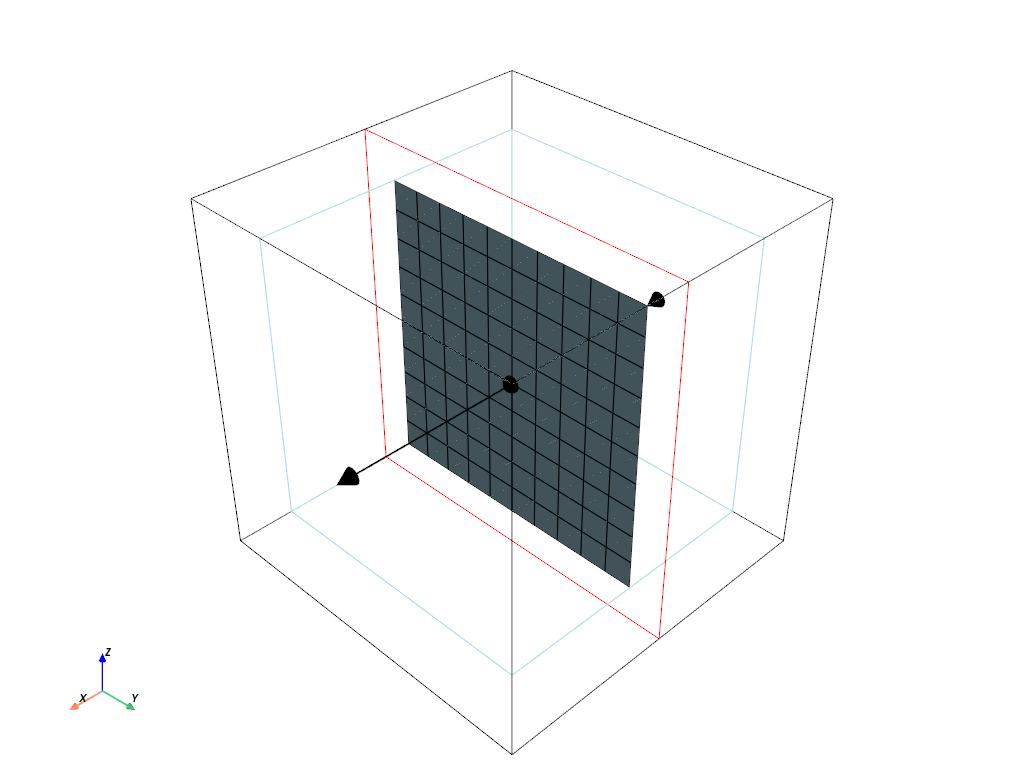

In [ ]:
pl = pv.Plotter()
mesh = meshes[15]
_ = pl.add_mesh(mesh.outline(), )
_ = pl.add_mesh_slice(mesh, normal=[1, 0, 0], show_edges = True)
pl.show_axes()
# pl.show_bounds()
pl.show()

#### Slider bar widget
For 

c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\spaan\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


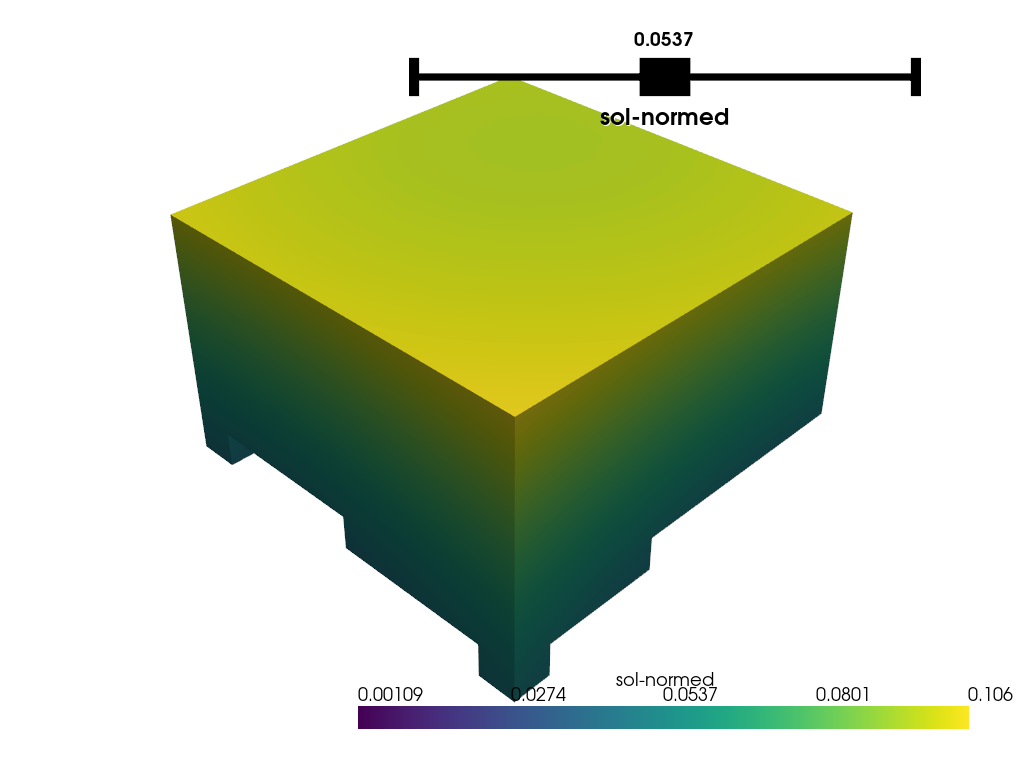

In [12]:
import pyvista as pv
from pyvista import examples

mesh = warped_mesh_hi

p = pv.Plotter()
p.add_mesh_threshold(mesh)
p.show()

### Setting more complicated boundary conditions
Below is Daniel's example code. Mesh-analysis notebook contains the modified bit for the solver.

In [ ]:
def makeDirichletBounds(d_X,d_Y,d_theta):
    
    """ Generates Dirichlet boundary conditions for a 3D numerical problem, although only x and
    y displacements are constrained. It takes into account x, y, and a rotation theta. The point is not taken
    as an explicit argument, but rather should be defined somewhere in the code. 

    Input:
        d_X (float, array-like): horizontal displacement of the node
        d_Y (float, array-like): vertical deisplacement of the node
        d_theta (float, array-like): rotation of the node, an angle

    Returns:
        float, list: list of the new nodal values.
    """
    #left boundary
    # local variables, defined relative to the center of the domain for y, normal for x 
    def L_dirichlet_val_r(point):
        y=point[1]-Ly/2.0
        x=point[0]
        return -d_X/2.0+x*np.cos(d_theta/2.0)-y*np.sin(d_theta/2.0)-x
    
    def L_dirichlet_val_u(point):
        y=point[1]-Ly/2.0
        x=point[0]
        return -d_Y/2.0+x*np.sin(d_theta/2.0)+y*np.cos(d_theta/2.0)-y

    #Right boundary
    def R_dirichlet_val_r(point):
        y=point[1]-Ly/2.0
        x=point[0]-Lx
        return d_X/2.0+x*np.cos(-d_theta/2.0)-y*np.sin(-d_theta/2.0)-x

    def R_dirichlet_val_u(point):
        y=point[1]-Ly/2.0
        x=point[0]-Lx
        return d_Y/2.0+x*np.sin(-d_theta/2.0)+y*np.cos(-d_theta/2.0)-y

    return [L_dirichlet_val_r,L_dirichlet_val_u,R_dirichlet_val_r,R_dirichlet_val_u]

# d_Xs=[-0.5,-0.5]
# d_Ys=[0.0,0.0]
# d_thetas=[0.5,-0.5]

""" Possible displacements. This tells you that the nodes are not allowed to move in 
y, only in x or rotation w. the prescribed values """
d_Xs=[-0.5]
d_Ys=[0.0]
d_thetas=[0.5]

#
fwd_preds=[]
problems=[]

for iii in range(len(d_Xs)):
    """ For each specified set of displacements, find the nodes at the boundaries 
    and set the displacement values for those nodes.

    Returns:
        _type_: _description_
    """


    d_X=d_Xs[iii]
    d_Y=d_Ys[iii]
    d_theta=d_thetas[iii]

    # Define boundary locations.
    boundtol=1e-5
    # left points, so specified by their x-coordinate
    def left(point):
        # change left to bottom, point[0] to point[2]
        return np.isclose(point[0], 0., atol=boundtol)

    # right points, so specified by their x-coordinate
    def right(point):
        # no need to fix the top --> that'll be the displacement
        return np.isclose(point[0], Lx, atol=boundtol)


    """ Define a list which contains the location of each boundary node, a [0,1] array 
    with as amny repetitions as there are boundary faces for the x(0) and y(1) coords, and finally 
    the displacement values by calling makeDirichletBounds(), which returns a list of four callables.

    """
                            #find - location funcs    #who is fixed? - vecs    #value funcs
    dirichlet_bc_info = [[left]*2+[right]*2, [0, 1]*2,makeDirichletBounds(d_X,d_Y,d_theta)] 
    # [left, left, right, right], [0, 1, 0, 1], [L_h, l_v, R_h, R_v]
    # so yeah, equal list lengths


    """
    In the original plasticity code they code it up a little different, but it's the
    same thing.

    Changes to be made:
    * disps = np.hstack((np.linspace(0., 0.1, 11)). Only compression for now, I want to release it at some point
    * location_fns = [[bottom]*3, top] (where those are callables)
    * vecs = [0,1,2,2] to fix all 3 directions of the bottom face and control the displ. of the top face in z
    * value_fns = [[dirichlet_val_bottom]*3, get_dirichlet_top(disps[0])]

    Oooh wait, yip yip. Indeed need to define it for each dof, so 4 in total.
    I modified the code, so let's try it out tomorrow on the computer.

    """


### 8. Try-out code
Some loose code snippets.

In [3]:
import numpy as np
# finding the center
Lx = 1
Ly = 1
Lz = 1
points = np.zeros((3,100))
center = np.array([[Lx/2], [Ly/2], [0]])
print(center)
for i in range(3):
    points[i] = np.linspace(0, Lx, 100)
center_nodes = np.isclose(points[:], center[:], atol = 1e-2)



[[0.5]
 [0.5]
 [0. ]]


takes mesh nodes, adds the solution (= deformation), and does this for each cell 
`(problem.fe.nodes+solution)[problem.fe.cells]`

NO. Don't so this, the new node positions are contained in solution, so I should be able to get the volume from there. Right?